In [62]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import table

In [63]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from simulation_data import get
from simulation_data.galaxies import GalaxyPopulation
my_galaxy_population = GalaxyPopulation()
from simulation_data.galaxies.galaxy import age_profile, get_star_formation_history, get_galaxy_particle_data, get_stellar_assembly_data, metallicity_profile, metals_profile, gasmetals_profile, metals_density_profile, metals_particle_profile, get_insitu, histmetals_density_profile, halfmass_rad_stars, stellar_density, gasmetals_density_profile, effective_yield, stellar_gas_densities, gasmetals_only, stellar_gas_metallicities, gas_mass, bimodal_check, starmetals_only, stellar_mass, get_stellar_age, gas_consumption

redshift = 2

In [6]:
with h5py.File('galaxy_population_data_'+str(redshift)+'.hdf5', 'r') as f:
    ids = f['ids'][:]
    median_age = f['median_age'][:]
    halfmass_radius = f['halfmass_radius'][:]
    total_mass = f['total_mass'][:]
#     halflight_radius_U = f['halflight_radius_U'][:]
#     halflight_radius_V = f['halflight_radius_V'][:]
#     halflight_radius_I = f['halflight_radius_I'][:]
    newbin_current_SFR = f['newbin_current_SFR'][:]
#     maximum_merger_ratio_30kpc_current_fraction = f['maximum_merger_ratio_30kpc_current_fraction'][:]
    FeH_Re = f['FeH_Re'][:]
    MgFe_Re = f['MgFe_Re'][:]
    MgH_Re = f['MgH_Re'][:]
    FeH_1kpc = f['FeH_1kpc'][:]
    MgFe_1kpc = f['MgFe_1kpc'][:]
    MgH_1kpc = f['MgH_1kpc'][:]
    gas_mass_1kpc = f['gas_mass_1kpc'][:]
    stellar_mass_1kpc = f['stellar_mass_1kpc'][:]
    OH_Re = f['OH_Re']
    OH_1kpc = f['OH_1kpc']
    OFe_Re = f['OFe_Re']
    OFe_1kpc = f['OFe_1kpc']
    FeH_gas_Re = f['FeH_gas_Re']
    FeH_gas_1kpc = f['FeH_gas_1kpc']
    OH_gas_Re = f['FeH_gas_Re']
    OH_gas_1kpc = f['FeH_gas_1kpc']

In [7]:
import warnings
warnings.filterwarnings('ignore')

# PSB_selection = (median_age<=1.2)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# intermediate_quiescent_selection = (median_age>1.2)&(median_age<=1.5)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# old_quiescent_selection = (median_age>1.5)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# starforming_selection = (np.log10(newbin_current_SFR/10**(total_mass))>-10.5)
# quiescent_selection = (np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# starforming_selection = (gas_mass_1kpc/stellar_mass_1kpc>0.025)
# quiescent_selection = (gas_mass_1kpc/stellar_mass_1kpc<0.025)
starforming_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))>-1.75)
quiescent_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))<=-1.75)

In [8]:
# start with a dictionary
sample_template = {
    'name': 'galaxy_name       ',
    'redshift': np.nan,
    'logMstar': np.nan,
    'Re': np.nan,              # kpc
    'x_err': np.nan,
    'age': np.nan,              # Gyr
    'age_err': np.nan,
    '[Fe/H]': np.nan,
    '[Fe/H]_err': np.nan,
    '[Mg/Fe]': np.nan,
    '[Mg/Fe]_err': np.nan,
    '[Mg/H]': np.nan,
    '[Mg/H]_err': np.nan,
}

# convert each value to a list of 100 identical objects
for k, v in sample_template.items():
    sample_template[k] = [v]*100

# convert dictionary of lists to a Table object 
sample_template = table.Table(sample_template)


sample_template[0:5]

name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [90]:
########################
# Kriek et al. (2016)
########################
# 1 galaxy, MOSFIRE spectrum, fit with Alf

kriek16 = sample_template[0:1].copy()
kriek16.meta['label'] = 'z~2 (Kriek et al. 2016)'

kriek16['name'] = 'COSMOS-11494'
kriek16['redshift'] = 2.1
kriek16['logMstar'] = 11.5
kriek16['Re'] = 2.1
kriek16['x_err'] = 0.1
kriek16['age'] = 2.71
kriek16['age_err'] = 0.22
kriek16['[Fe/H]'] = -0.25
kriek16['[Fe/H]_err'] = 0.11
kriek16['[Mg/Fe]'] = 0.59
kriek16['[Mg/Fe]_err'] = 0.11
kriek16['[Mg/H]'] = kriek16['[Mg/Fe]'] + kriek16['[Fe/H]']
kriek16['[Mg/H]_err'] = np.sqrt( kriek16['[Mg/Fe]_err']**2 + kriek16['[Fe/H]_err']**2 )

# print out table
kriek16



name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
COSMOS-11494,2.1,11.5,2.1,0.1,2.71,0.22,-0.25,0.11,0.59,0.11,0.33999999999999997,0.15556349186104046


In [89]:
########################
# Beverage et al. (2021)
########################
# 67 galaxies

name = []
rredshift = []
logMstar = []
Re = []
age = []
age_err = []
FeH = []
FeH_err = []
MgFe = []
MgFe_err = []
MgH = []
MgH_err = []

with open('beverage21_legacDR2_results.dat', 'r') as f:
    next(f)
    for row in f:
        line=row.rstrip().split(' ')
#         line = [float(bang) for bang in bing[1:]]
        name.append(line[0])
        rredshift.append(float(line[1]))
        logMstar.append(float(line[3]))
        Re.append(float(line[6]))
        age.append(float(line[21]))
        age_err.append((float(line[22])+float(line[23])/2))
        FeH.append(float(line[9]))
        FeH_err.append((float(line[10])+float(line[11])/2))
        MgFe.append(float(line[15]))
        MgFe_err.append((float(line[16])+float(line[17])/2))
        MgH.append(float(line[12]))
        MgH_err.append((float(line[13])+float(line[14])/2))
        
bev21 = sample_template[0:len(name)].copy()
bev21.meta['label'] = 'z~0.7 (Beverage et al. 2021)'

bev21['name'] = name
bev21['redshift'] = rredshift 
bev21['logMstar'] = logMstar
bev21['Re'] = Re 
bev21['x_err'] = np.full(len(name), 0.1)
bev21['age'] = 10**np.array(age) 
bev21['age_err'] = 10**np.array(age_err) 
bev21['[Fe/H]'] = FeH
bev21['[Fe/H]_err'] = FeH_err
bev21['[Mg/Fe]'] = MgFe
bev21['[Mg/Fe]_err'] = MgFe_err
bev21['[Mg/H]'] = MgH
bev21['[Mg/H]_err'] = MgH_err

# print out table
bev21

name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
M10_187035,0.6178,10.8601,4.3386,0.1,8.13392193567162,1.1019198334508078,-0.4203,0.03855,0.333,0.0337,-0.0882,0.04775
M10_213772,0.7004,11.6928,7.3291,0.1,7.301296749459656,1.0916916788093647,-0.1732,0.0435,0.1084,0.02915,-0.0623,0.049550000000000004
M10_215519,0.6146,10.4456,1.1985,0.1,6.617592187056603,1.3179532336685458,-0.3161,0.10930000000000001,0.4036,0.08145,0.0857,0.13345
M10_218656,0.6183,10.8536,2.6266,0.1,8.120822162499834,1.1780127744628046,-0.4795,0.08255,0.3169,0.0637,-0.1633,0.0761
M10_219083,0.7054,11.0723,6.3296,0.1,5.8156732771851445,1.1485502481999437,-0.2938,0.061149999999999996,0.3068,0.0615,0.0128,0.09040000000000001
M10_225441,0.6823,10.6554,0.7695,0.1,2.1325538179462007,1.0693010665477825,-0.1586,0.0576,0.2401,0.04995,0.0831,0.06835
M10_227672,0.6093,10.6166,3.542,0.1,5.001496854402788,1.2139477653658286,-0.3443,0.07225,0.3348,0.0664,-0.0144,0.1046
M10_228380,0.6114,11.1953,6.7543,0.1,7.950601750844197,1.0987528131180708,-0.428,0.0403,0.3113,0.03455,-0.1166,0.04325
M10_230983,0.6961,10.9875,4.0335,0.1,5.3777424596344225,1.4055619763755018,-0.1792,0.1227,0.2368,0.0743,0.0474,0.14295


In [88]:
########################
# Kriek et al. (2019)
########################
# 5 galaxies, LRIS+MOSFIRE spectra, fit with Alf

kriek19 = sample_template[0:3].copy()
kriek19.meta['label'] = 'z~1.4 (Kriek et al. 2019)'

kriek19['name'] = [214340, 213931, 214695] #217249, 213947, 
kriek19['redshift'] = [1.418, 1.399, 1.396] #1.377, 1.397, 
kriek19['logMstar'] = [10.80, 11.73, 11.18] #10.61, 10.87, 
kriek19['Re'] = 10**np.array([0.52, 0.62, 0.29]) #-0.3, -0.2, 
kriek19['x_err'] = [0.1, 0.1, 0.1]
kriek19['age'] = [3.8, 3.1, 4.5] #3.0, 3.0, 
kriek19['age_err'] = [3.0, 0.2, 2.1] # mean of upper and lower uncertainty #0.5, 0.6, 
kriek19['[Fe/H]'] = [-0.42, -0.27, -0.20] #-1.03, -0.89, 
kriek19['[Fe/H]_err'] = [0.20, 0.07, 0.20] # mean of upper and lower uncertainty #0.37, 0.46, 
kriek19['[Mg/Fe]'] = [0.22, 0.44, 0.28] #0.52, 0.57, 
kriek19['[Mg/Fe]_err'] = [0.17, 0.08, 0.15] #0.32, 0.28, 
kriek19['[Mg/H]'] = kriek19['[Mg/Fe]'] + kriek19['[Fe/H]']
kriek19['[Mg/H]_err'] = np.sqrt( kriek19['[Mg/Fe]_err']**2 + kriek19['[Fe/H]_err']**2 )

# following the paper, we discard the first two galaxies because very young
# and with uncertain abundance measurements

# kriek19_discarded = kriek19[0:2]
# kriek19_discarded.meta['label'] = 'Kriek et al. (2019) discarded'
# kriek19 = kriek19[2:]

# print out table
kriek19



name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
214340,1.418,10.8,3.311311214825911,0.1,3.8,3.0,-0.42,0.2,0.22,0.17,-0.19999999999999998,0.2624880949681338
213931,1.399,11.73,4.168693834703354,0.1,3.1,0.2,-0.27,0.07,0.44,0.08,0.16999999999999998,0.1063014581273465
214695,1.396,11.18,1.9498445997580451,0.1,4.5,2.1,-0.2,0.2,0.28,0.15,0.08000000000000002,0.25


In [56]:
# print out table of discarded galaxies
# kriek19_discarded


name,redshift,logMstar,Re,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
217249,1.377,10.61,0.5011872336272722,3.0,0.5,-1.03,0.37,0.52,0.32,-0.51,0.48918299234540036
213947,1.397,10.87,0.6309573444801932,3.0,0.6,-0.89,0.46,0.57,0.28,-0.32000000000000006,0.5385164807134505


In [87]:
########################
# Jafariyazani et al. (2020)
########################
# 1 galaxy, MOSFIRE spectrum, fit with Alf

jafa20 = sample_template[0:1].copy()
jafa20.meta['label'] = 'z~2 (Jafariyazani et al. 2020)'

jafa20['name'] = 'MRG-M0138'
jafa20['redshift'] = 1.98
jafa20['logMstar'] = 11.69
jafa20['Re'] = 4.8
jafa20['x_err'] = 0.1
jafa20['age'] = 1.37
jafa20['age_err'] = 0.11
jafa20['[Fe/H]'] = 0.26
jafa20['[Fe/H]_err'] = 0.04
jafa20['[Mg/Fe]'] = 0.51
jafa20['[Mg/Fe]_err'] = 0.05
jafa20['[Mg/H]'] = jafa20['[Mg/Fe]'] + jafa20['[Fe/H]']
jafa20['[Mg/H]_err'] = np.sqrt( jafa20['[Mg/Fe]_err']**2 + jafa20['[Fe/H]_err']**2 )

# print out table
jafa20



name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MRG-M0138,1.98,11.69,4.8,0.1,1.37,0.11,0.26,0.04,0.51,0.05,0.77,0.06403124237432849


In [86]:
########################
# Carnall et al. (2021)
########################
# dozens of galaxies at z~1.15

carn21 = sample_template[0:1].copy()
carn21.meta['label'] = 'z~1.15 (Carnall et al. 2021)'

carn21['name'] = 'MRG-M0138'
carn21['redshift'] = 1.15
carn21['logMstar'] = 11.05
carn21['Re'] = None # not found in paper
carn21['x_err'] = 0.1
carn21['age'] = None
carn21['age_err'] = None
carn21['[Fe/H]'] = -0.18
carn21['[Fe/H]_err'] = 0.08
carn21['[Mg/Fe]'] = 0.23
carn21['[Mg/Fe]_err'] = 0.12
carn21['[Mg/H]'] = carn21['[Mg/Fe]'] + carn21['[Fe/H]']
carn21['[Mg/H]_err'] = np.sqrt( carn21['[Mg/Fe]_err']**2 + carn21['[Fe/H]_err']**2 )

# print out table
carn21

name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MRG-M0138,1.15,11.05,nan,0.1,nan,nan,-0.18,0.08,0.23,0.12,0.05000000000000002,0.14422205101855956


In [99]:
# set the marker properties for the plots


kriek16.meta['color'] = 'darkslateblue'
kriek16.meta['markersize'] = 8
kriek16.meta['marker'] = 'D'
kriek16.meta['alpha'] = 0.8
kriek16.meta['zorder'] = 100

kriek19.meta['color'] = 'green'
kriek19.meta['markersize'] = 12
kriek19.meta['marker'] = 'v'
kriek19.meta['alpha'] = 0.8
kriek19.meta['zorder'] = 100

# kriek19_discarded.meta['color'] = 'orange'
# kriek19_discarded.meta['markersize'] = 12
# kriek19_discarded.meta['marker'] = 'o'
# kriek19_discarded.meta['alpha'] = 0.2

jafa20.meta['color'] = 'chocolate'
jafa20.meta['markersize'] = 12
jafa20.meta['marker'] = 's'
jafa20.meta['alpha'] = 0.8
jafa20.meta['zorder'] = 100

carn21.meta['color'] = 'crimson'
carn21.meta['markersize'] = 12
carn21.meta['marker'] = 'p'
carn21.meta['alpha'] = 0.8
carn21.meta['zorder'] = 100

bev21.meta['color'] = 'darkgray'
bev21.meta['markersize'] = 6
bev21.meta['marker'] = 'H'
bev21.meta['alpha'] = 0.8

fts = 12
ftss = 11


In [100]:
# put samples together
samples = [kriek16, kriek19, jafa20, carn21, bev21] #, kriek19_discarded, jafa20]

# this one is to suppress the line connecting points
for s in samples:
    s.meta['linestyle'] = ''

[Text(0.5, 0, 'log $M_\\ast/M_\\odot$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.9),
 (9.7, 12.0)]

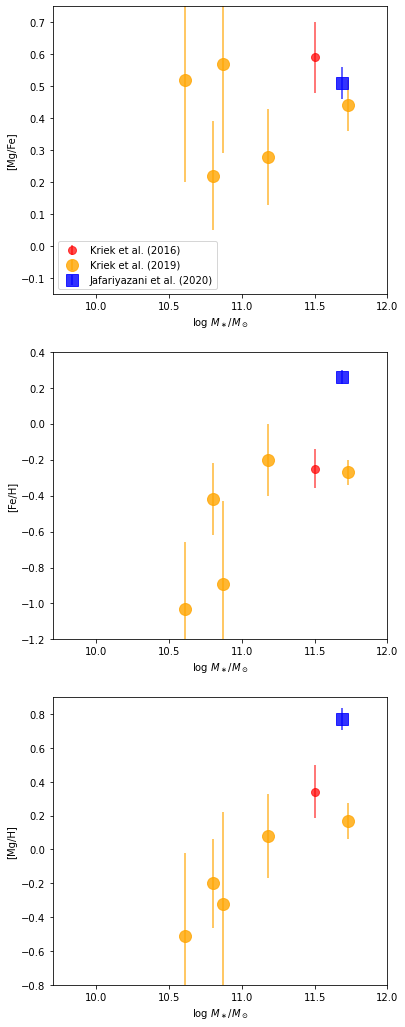

In [12]:

# plot of abundances vs stellar mass

fig, axs = plt.subplots(3, 1, figsize=(6,18))


# [Mg/Fe]
##########

for s in samples:
    axs[0].errorbar(s['logMstar'], s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[9.7, 12])
axs[0].legend(loc='lower left')



# [Fe/H]
##########

for s in samples:
    axs[1].errorbar(s['logMstar'], s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[9.7, 12])


# [Mg/H]
##########

for s in samples:
    axs[2].errorbar(s['logMstar'], s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.9], xlim=[9.7, 12])


[Text(0.5, 0, 'log $M_\\ast/M_\\odot$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.9),
 (10.5, 12.0)]

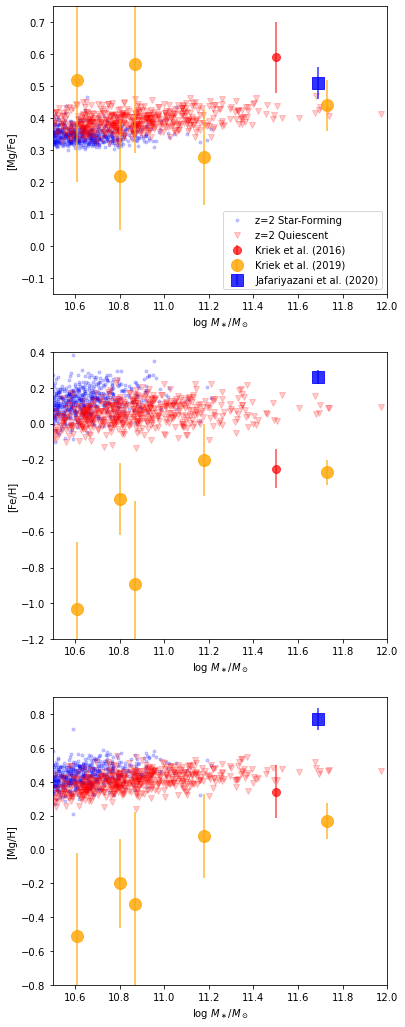

In [27]:

# plot of abundances vs stellar mass

fig, axs = plt.subplots(3, 1, figsize=(6,18))
markersize = 6


# [Mg/Fe]
##########

# z=2 galaxies
axs[0].plot(total_mass[starforming_selection], MgFe_1kpc[starforming_selection], 'b.',
           alpha=0.2, label='z=2 Star-Forming', markersize=markersize, zorder=0)
axs[0].plot(total_mass[quiescent_selection], MgFe_1kpc[quiescent_selection], 'rv',
           alpha=0.2, label='z=2 Quiescent', markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[0].errorbar(s['logMstar'], s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[10.5, 12])
axs[0].legend(loc='lower right')



# [Fe/H]
##########

# z=2 galaxies
axs[1].plot(total_mass[starforming_selection], FeH_1kpc[starforming_selection], 'b.',
           alpha=0.2, markersize=markersize, zorder=0)
axs[1].plot(total_mass[quiescent_selection], FeH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[1].errorbar(s['logMstar'], s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[10.5, 12])


# [Mg/H]
##########

# z=2 galaxies
axs[2].plot(total_mass[starforming_selection], MgH_1kpc[starforming_selection], 'b.',
           alpha=0.2, markersize=markersize, zorder=0)
axs[2].plot(total_mass[quiescent_selection], MgH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[2].errorbar(s['logMstar'], s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.9], xlim=[10.5, 12])


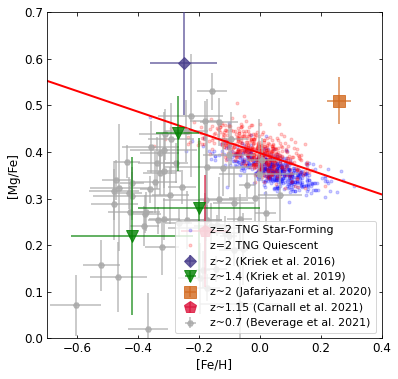

In [120]:

# [Mg/Fe] vs [Fe/H]
####################

def func(x, m, b):
    y = m*x + b
    return y

fig, ax = plt.subplots(figsize=(6,6))

markersize = 6
alpha = 0.2

# z=2 galaxies
ax.plot(FeH_Re[starforming_selection], MgFe_Re[starforming_selection], 'b.',
           alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
ax.plot(FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection], 'r.',
           alpha=alpha, label='z='+str(redshift)+' TNG Quiescent', markersize=markersize, zorder=0)

optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
xx = np.array([-0.7, 0.4])
ax.plot(xx, func(xx, *optParam), '-', color='r', linewidth=2)

# observations
for s in samples:
    ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
      ylim=[0.0, 0.7], xlim=[-0.7, 0.4])
plt.rcParams['axes.labelsize'] = fts+1
ax.tick_params(direction='in', which='both', labelsize=fts, bottom=True, top=True, left=True, right=True)
ax.legend(loc='lower right', fontsize=ftss).set_zorder(200)

plt.savefig('2022 FIGURES\z2_MgFeFeH.png', dpi=100, bbox_inches='tight')
plt.show()

In [118]:
print(optParam)

[-0.22162942  0.39764619]


[Text(0.5, 0, 'log $R_e / kpc$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.8),
 (-0.5, 1.0)]

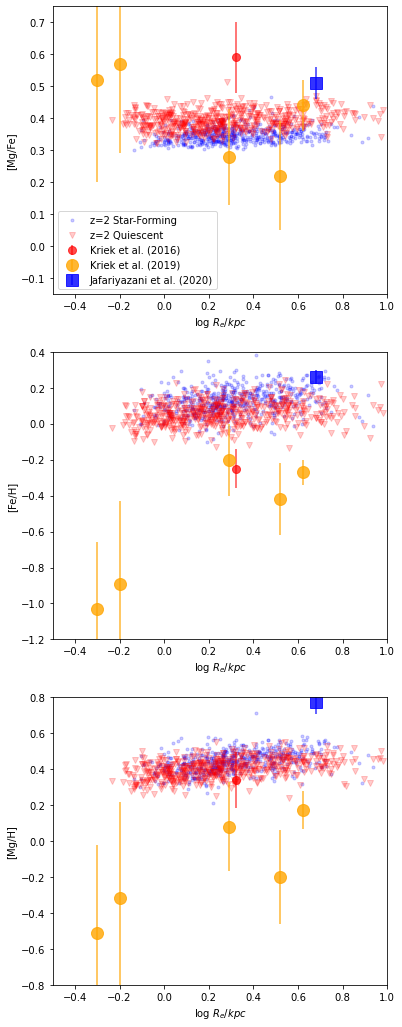

In [38]:

# plot of abundances vs effective size

fig, axs = plt.subplots(3, 1, figsize=(6,18))


# [Mg/Fe]
##########

# z=2 galaxies
axs[0].plot(np.log10(halfmass_radius[starforming_selection]), MgFe_1kpc[starforming_selection], 'b.', 
            alpha=0.2, label='z=2 Star-Forming', markersize=markersize, zorder=0)
axs[0].plot(np.log10(halfmass_radius[quiescent_selection]), MgFe_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, label='z=2 Quiescent', markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[0].errorbar(np.log10(s['Re']), s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[-0.5, 1.0])
axs[0].legend(loc='lower left')



# [Fe/H]
##########

# z=2 galaxies
axs[1].plot(np.log10(halfmass_radius[starforming_selection]), FeH_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[1].plot(np.log10(halfmass_radius[quiescent_selection]), FeH_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[1].errorbar(np.log10(s['Re']), s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $R_e / kpc$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[-0.5, 1.0])


# [Mg/H]
##########

# z=2 galaxies
axs[2].plot(np.log10(halfmass_radius[starforming_selection]), MgH_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[2].plot(np.log10(halfmass_radius[quiescent_selection]), MgH_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[2].errorbar(np.log10(s['Re']), s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.8], xlim=[-0.5, 1.0])


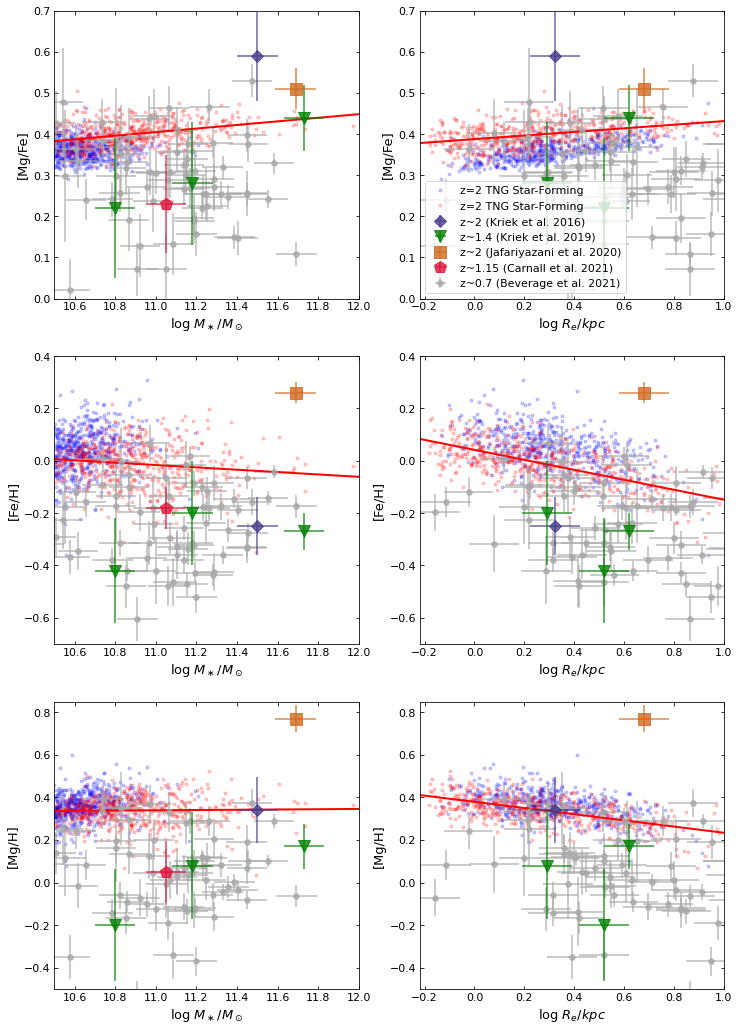

In [119]:

# plot of abundances vs stellar mass and effective size

fig, axs = plt.subplots(3, 2, figsize=(12,18))
markersize = 6
alpha = 0.2

def func(x, m, b):
    y = m*x + b
    return y

params = []

##### STELLAR MASS #######################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[0][0].plot(total_mass[starforming_selection], MgFe_Re[starforming_selection], 'b.',
           alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
axs[0][0].plot(total_mass[quiescent_selection], MgFe_Re[quiescent_selection], 'r.',
           alpha=alpha, label='z='+str(redshift)+' TNG Quiescent', markersize=markersize, zorder=0)

optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgFe_Re[quiescent_selection])
params.append(optParam)
xx = np.array([10.5, 12])
axs[0][0].plot(xx, func(xx, *optParam), '-', color='r', linewidth=2)

# observations
for s in samples:
    axs[0][0].errorbar(s['logMstar'], s['[Mg/Fe]'], xerr=s['x_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[0, 0.7], xlim=[10.5, 12])



# [Fe/H]
##########

# z=2 galaxies
axs[1][0].plot(total_mass[starforming_selection], FeH_Re[starforming_selection], 'b.',
           alpha=alpha, markersize=markersize, zorder=0)
axs[1][0].plot(total_mass[quiescent_selection], FeH_Re[quiescent_selection], 'r.',
           alpha=alpha, markersize=markersize, zorder=0)

optParam, pcov = curve_fit(func, total_mass[quiescent_selection], FeH_Re[quiescent_selection])
params.append(optParam)
xx = np.array([10.5, 12])
axs[1][0].plot(xx, func(xx, *optParam), '-', color='r', linewidth=2)

# observations
for s in samples:
    axs[1][0].errorbar(s['logMstar'], s['[Fe/H]'], xerr=s['x_err'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-0.7, 0.4], xlim=[10.5, 12])


# [Mg/H]
##########

# z=2 galaxies
axs[2][0].plot(total_mass[starforming_selection], MgH_Re[starforming_selection], 'b.',
           alpha=alpha, markersize=markersize, zorder=0)
axs[2][0].plot(total_mass[quiescent_selection], MgH_Re[quiescent_selection], 'r.',
           alpha=alpha, markersize=markersize, zorder=0)

optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgH_Re[quiescent_selection])
params.append(optParam)
xx = np.array([10.5, 12])
axs[2][0].plot(xx, func(xx, *optParam), '-', color='r', linewidth=2)

# observations
for s in samples:
    axs[2][0].errorbar(s['logMstar'], s['[Mg/H]'], xerr=s['x_err'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.5, 0.85], xlim=[10.5, 12])


##### EFFECTIVE SIZE ########################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[0][1].plot(np.log10(halfmass_radius[starforming_selection]), MgFe_Re[starforming_selection], 'b.', 
            alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
axs[0][1].plot(np.log10(halfmass_radius[quiescent_selection]), MgFe_Re[quiescent_selection], 'r.', 
            alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)

optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), MgFe_Re[quiescent_selection])
params.append(optParam)
xx = np.array([-0.22, 1.0])
axs[0][1].plot(xx, func(xx, *optParam), '-', color='r', linewidth=2)

# observations
for s in samples:
    axs[0][1].errorbar(np.log10(s['Re']), s['[Mg/Fe]'], xerr=s['x_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/Fe]',
      ylim=[0, 0.7], xlim=[-0.22, 1.0])
axs[0][1].legend(loc='lower left', fontsize=ftss).set_zorder(200)


# [Fe/H]
##########

# z=2 galaxies
axs[1][1].plot(np.log10(halfmass_radius[starforming_selection]), FeH_Re[starforming_selection], 'b.', 
            alpha=alpha, markersize=markersize, zorder=0)
axs[1][1].plot(np.log10(halfmass_radius[quiescent_selection]), FeH_Re[quiescent_selection], 'r.', 
            alpha=alpha, markersize=markersize, zorder=0)

optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), FeH_Re[quiescent_selection])
params.append(optParam)
xx = np.array([-0.22, 1.0])
axs[1][1].plot(xx, func(xx, *optParam), '-', color='r', linewidth=2)

# observations
for s in samples:
    axs[1][1].errorbar(np.log10(s['Re']), s['[Fe/H]'], xerr=s['x_err'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Fe/H]',
      ylim=[-0.7, 0.4], xlim=[-0.22, 1.0])


# [Mg/H]
##########

# z=2 galaxies
axs[2][1].plot(np.log10(halfmass_radius[starforming_selection]), MgH_Re[starforming_selection], 'b.', 
            alpha=alpha, markersize=markersize, zorder=0)
axs[2][1].plot(np.log10(halfmass_radius[quiescent_selection]), MgH_Re[quiescent_selection], 'r.', 
            alpha=alpha, markersize=markersize, zorder=0)

optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), MgH_Re[quiescent_selection])
params.append(optParam)
xx = np.array([-0.22, 1.0])
axs[2][1].plot(xx, func(xx, *optParam), '-', color='r', linewidth=2)

# observations
for s in samples:
    axs[2][1].errorbar(np.log10(s['Re']), s['[Mg/H]'], xerr=s['x_err'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/H]',
      ylim=[-0.5, 0.85], xlim=[-0.22, 1.0])

plt.rcParams['axes.labelsize'] = fts
for bip in axs:
    for bop in bip:
        bop.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

plt.savefig('2022 FIGURES\z2_bigcheddar.png', dpi=100, bbox_inches='tight')
plt.show()

In [116]:
print(params)

[array([ 0.0436658 , -0.07542444]), array([-0.04506826,  0.47971148]), array([0.00617531, 0.27186572]), array([0.04384329, 0.3879252 ]), array([-0.19065109,  0.04186939]), array([-0.14510287,  0.37942294])]
